In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
/device:GPU:0
Found GPU at: /device:GPU:0


In [2]:
#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import Xception
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout,Input
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential, Model
# Utils
import os
import cv2
from sklearn.utils import shuffle
from pathlib import Path
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
#mount drive
from google.colab import drive
drive.mount("/content/drive")

#Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

# Core
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns;
from glob import glob 
import random

Mounted at /content/drive


In [3]:
def img_Generator(file_name,gen_type,size):
    if gen_type=='yes':
        generet_Data=ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
        gen_data=generet_Data.flow_from_directory(file_name,target_size=(size, size),
                                                  batch_size=32,shuffle=True,
                                                  class_mode='categorical')
                
    else:
        generet_Data1=ImageDataGenerator()
        gen_data=generet_Data1.flow_from_directory(file_name,target_size=(size, size),
                                                  batch_size=32,shuffle=False,
                                                  class_mode='categorical')
    
    return gen_data

In [4]:
#Xception
xception_size=299
image_path=Path('/content/drive/MyDrive/TA/Data/0_3_Split')
data_typ='yes'
train_data=img_Generator(str(image_path)+'/train/',data_typ,xception_size)
data_typ='no'
test_data=img_Generator(str(image_path)+'/test/',data_typ,xception_size)

Found 2876 images belonging to 10 classes.
Found 1193 images belonging to 10 classes.


In [5]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [6]:
xception_base_model = Xception(include_top=False,weights='imagenet',input_shape = (xception_size,xception_size,3))

83683744/83683744 [==============================] - 1s 0us/step


In [7]:
print("weights:", len(xception_base_model.weights))
print("trainable_weights:", len(xception_base_model.trainable_weights))
print("non_trainable_weights:", len(xception_base_model.non_trainable_weights))

weights: 234
trainable_weights: 154
non_trainable_weights: 80


In [8]:

trainable_layer = int(30/100*int(len(xception_base_model.weights)))
print(trainable_layer)

70


In [9]:
#remove any dense layer from model
for layer in xception_base_model.layers:
    layer.trainable = False
for layer in xception_base_model.layers[-trainable_layer:]:
    layer.trainable = True

In [10]:
print("weights:", len(xception_base_model.weights))
print("trainable_weights:", len(xception_base_model.trainable_weights))
print("non_trainable_weights:", len(xception_base_model.non_trainable_weights))

weights: 234
trainable_weights: 83
non_trainable_weights: 151


In [11]:
excmodel = Sequential()
excmodel.add(xception_base_model)
excmodel.add(layers.Flatten())
# excmodel.add(layers.Dense(1024 ,activation='relu'))
excmodel.add(BatchNormalization())
excmodel.add(Dropout(0.2))
excmodel.add(layers.Dense(10, activation ='softmax'))
excmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 flatten (Flatten)           (None, 204800)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 204800)           819200    
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 204800)            0         
                                                                 
 dense (Dense)               (None, 10)                2048010   
                                                                 
Total params: 23,728,690
Trainable params: 17,853,866
Non-trainable params: 5,874,824
____________________________________

In [12]:
excmodel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
batch_size = 32
# Training model
n_training_samples = len(train_data)
t0 = time.time()
xception_history = excmodel.fit(
    train_data,
    epochs=200,
    #  validation_data=val_data,
    # steps_per_epoch =(n_training_samples//batch_size)*2,
    shuffle = True,
    callbacks=callbacks_list
    )
record_time =time.time()-t0
print("Training time:", record_time)

Epoch 1/200
90/90 [==============================] - 908s 10s/step - loss: 2.6741 - accuracy: 0.1495 - lr: 0.0010
Epoch 2/200
90/90 [==============================] - 84s 936ms/step - loss: 2.3582 - accuracy: 0.1735 - lr: 0.0010
Epoch 3/200
90/90 [==============================] - 83s 922ms/step - loss: 2.3976 - accuracy: 0.2031 - lr: 0.0010
Epoch 4/200
90/90 [==============================] - ETA: 0s - loss: 2.7569 - accuracy: 0.1756
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
90/90 [==============================] - 84s 926ms/step - loss: 2.7569 - accuracy: 0.1756 - lr: 0.0010
Epoch 5/200
90/90 [==============================] - 84s 925ms/step - loss: 2.4544 - accuracy: 0.2208 - lr: 3.0000e-04
Epoch 6/200
90/90 [==============================] - 82s 910ms/step - loss: 2.0949 - accuracy: 0.2583 - lr: 3.0000e-04
Epoch 7/200
90/90 [==============================] - 83s 920ms/step - loss: 2.0521 - accuracy: 0.2709 - lr: 3.0000e-04
Epoch 8/200
90/90 [======

In [14]:
#save the model
excmodel.save('/content/drive/MyDrive/TA/Models/Xception/Xception_Adam_30_dropouts')

38/38 [==============================] - 377s 10s/step


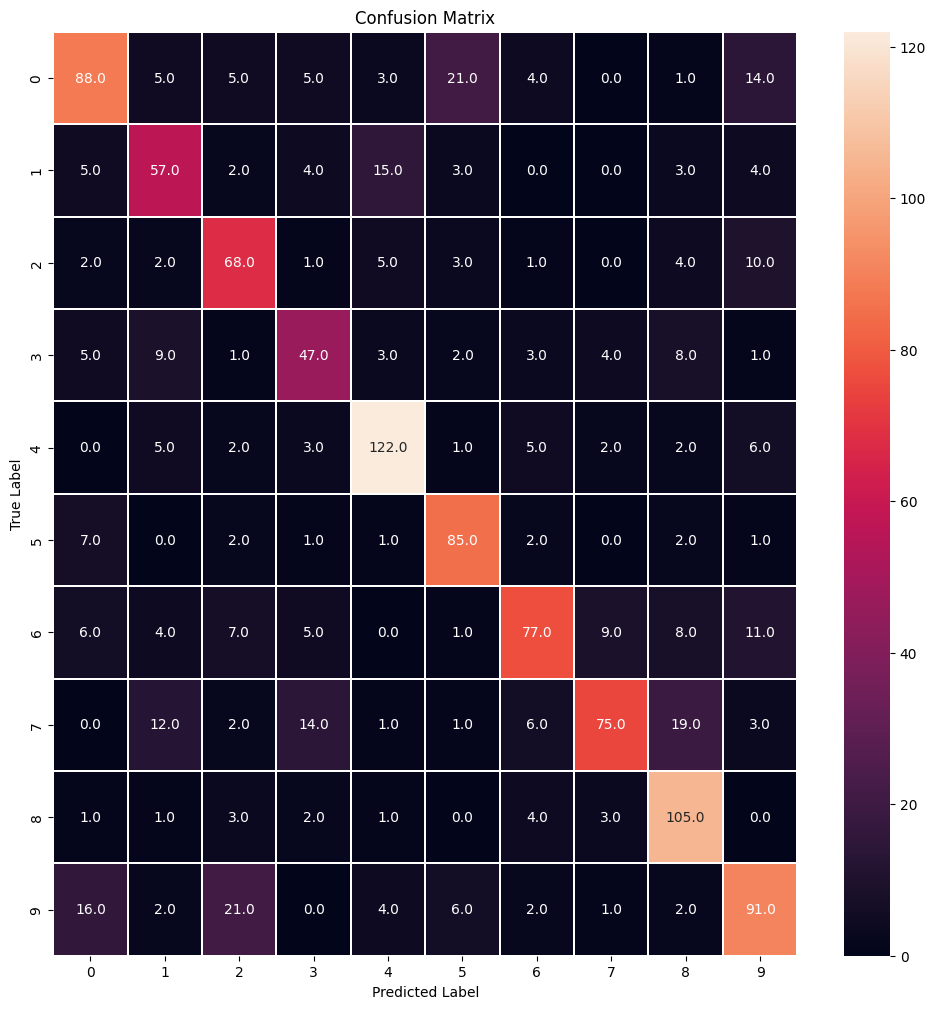

In [15]:
y_val = test_data.classes
y_pred = excmodel.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, y_val)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# ax.xaxis.set_ticklabels(test_data.class_indices)
# ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [16]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_pred, y_val)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_pred, y_val, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_pred, y_val, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, y_val, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.683152
Precision: 0.678311
Recall: 0.682421
F1 score: 0.674968
